In [4]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium 
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
print("load libralies completed")

load libralies completed


In [83]:
def geo_location(address):
    
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'SJVNROHFKAQ0CZ5ULIM0V5K5IXUPI2UV1FARMVENUHS3HB4F'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='W1H0JXEDQWHBWX1ZZYT2IXCRTWLGPSNQ2NOGQ5IA4ZKCQKEU' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_venue_details(venue_id):
        
    CLIENT_ID = 'YWPEEZL3QYJCG11IK4XOTUF0VQNVBCY35X0RJ40PHBCX5H1B'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='OJA02MIRPN22O13QPFHM0SJNZUSXMM2UCA5LMWMS2EMIAC0W' # Foursquare Secret, note there is a daily call quota it it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    features=resp['features']
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [6]:
new_york_data=get_new_york_data()

In [7]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Text(0,0.5,'Number of Neighborhood')

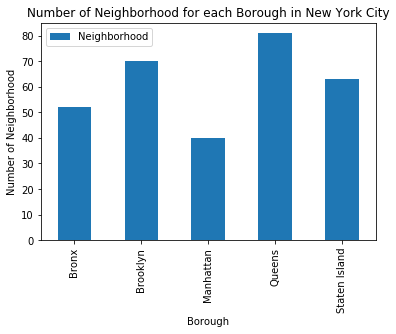

In [31]:
import seaborn as sbn
z = new_york_data.groupby('Borough')['Neighborhood'].count()
z=z.to_frame()
ax=z.plot.bar(y='Neighborhood',
           title='Number of Neighborhood for each Borough in New York City'
           )
ax.set_ylabel('Number of Neighborhood')



In [32]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
Thai_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    Thai_resturants=venues[venues['Category']=='Thai Restaurant']   
    print('(',count,'/',len(new_york_data),')','Thai Resturants in '+Neighborhood+', '+Borough+':'+str(len(Thai_resturants)))
    for resturant_detail in Thai_resturants.values.tolist():
        id, name , category=resturant_detail
        Thai_rest_ny = Thai_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Thai Resturants in Wakefield, Bronx:0
( 2 / 306 ) Thai Resturants in Co-op City, Bronx:0
( 3 / 306 ) Thai Resturants in Eastchester, Bronx:0
( 4 / 306 ) Thai Resturants in Fieldston, Bronx:0
( 5 / 306 ) Thai Resturants in Riverdale, Bronx:1
( 6 / 306 ) Thai Resturants in Kingsbridge, Bronx:1
( 7 / 306 ) Thai Resturants in Marble Hill, Manhattan:1
( 8 / 306 ) Thai Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Thai Resturants in Norwood, Bronx:0
( 10 / 306 ) Thai Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Thai Resturants in Baychester, Bronx:0
( 12 / 306 ) Thai Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Thai Resturants in City Island, Bronx:0
( 14 / 306 ) Thai Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Thai Resturants in University Heights, Bronx:0
( 16 / 306 ) Thai Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Thai Resturants in Fordham, Bronx:0
( 18 / 306 ) Thai Resturants in East Tremont, Bronx:0
( 19 / 306 ) Thai Resturants in West Farms, Bronx:0


( 148 / 306 ) Thai Resturants in Ozone Park, Queens:0
( 149 / 306 ) Thai Resturants in South Ozone Park, Queens:1
( 150 / 306 ) Thai Resturants in College Point, Queens:0
( 151 / 306 ) Thai Resturants in Whitestone, Queens:0
( 152 / 306 ) Thai Resturants in Bayside, Queens:2
( 153 / 306 ) Thai Resturants in Auburndale, Queens:1
( 154 / 306 ) Thai Resturants in Little Neck, Queens:1
( 155 / 306 ) Thai Resturants in Douglaston, Queens:1
( 156 / 306 ) Thai Resturants in Glen Oaks, Queens:1
( 157 / 306 ) Thai Resturants in Bellerose, Queens:0
( 158 / 306 ) Thai Resturants in Kew Gardens Hills, Queens:0
( 159 / 306 ) Thai Resturants in Fresh Meadows, Queens:1
( 160 / 306 ) Thai Resturants in Briarwood, Queens:0
( 161 / 306 ) Thai Resturants in Jamaica Center, Queens:1
( 162 / 306 ) Thai Resturants in Oakland Gardens, Queens:0
( 163 / 306 ) Thai Resturants in Queens Village, Queens:0
( 164 / 306 ) Thai Resturants in Hollis, Queens:0
( 165 / 306 ) Thai Resturants in South Jamaica, Queens:0
( 

( 289 / 306 ) Thai Resturants in Roxbury, Queens:0
( 290 / 306 ) Thai Resturants in Homecrest, Brooklyn:0
( 291 / 306 ) Thai Resturants in Middle Village, Queens:0
( 292 / 306 ) Thai Resturants in Prince's Bay, Staten Island:0
( 293 / 306 ) Thai Resturants in Lighthouse Hill, Staten Island:0
( 294 / 306 ) Thai Resturants in Richmond Valley, Staten Island:0
( 295 / 306 ) Thai Resturants in Malba, Queens:0
( 296 / 306 ) Thai Resturants in Highland Park, Brooklyn:0
( 297 / 306 ) Thai Resturants in Madison, Brooklyn:0
( 298 / 306 ) Thai Resturants in Bronxdale, Bronx:0
( 299 / 306 ) Thai Resturants in Allerton, Bronx:0
( 300 / 306 ) Thai Resturants in Kingsbridge Heights, Bronx:0
( 301 / 306 ) Thai Resturants in Erasmus, Brooklyn:0
( 302 / 306 ) Thai Resturants in Hudson Yards, Manhattan:1
( 303 / 306 ) Thai Resturants in Hammels, Queens:1
( 304 / 306 ) Thai Resturants in Bayswater, Queens:0
( 305 / 306 ) Thai Resturants in Queensbridge, Queens:1
( 306 / 306 ) Thai Resturants in Fox Hills,

In [34]:
Thai_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,4b94a4a2f964a520787f34e3,Nam Thai
1,Bronx,Kingsbridge,4b94a4a2f964a520787f34e3,Nam Thai
2,Manhattan,Marble Hill,4a739e29f964a520f5dc1fe3,Siam Square
3,Bronx,Country Club,4b4c90d3f964a52046b626e3,Honey's Thai Pavilion
4,Bronx,Parkchester,5585c948498e0bd8a8a706f1,Thai Cuisine


In [49]:
z1=Thai_rest_ny.groupby(['Borough'])['Borough'].count()
z1=z1.to_frame()
z1.rename(columns={'Borough':'count'})

,count
Borough,
Bronx,9
Brooklyn,40
Manhattan,37
Queens,54
Staten Island,4


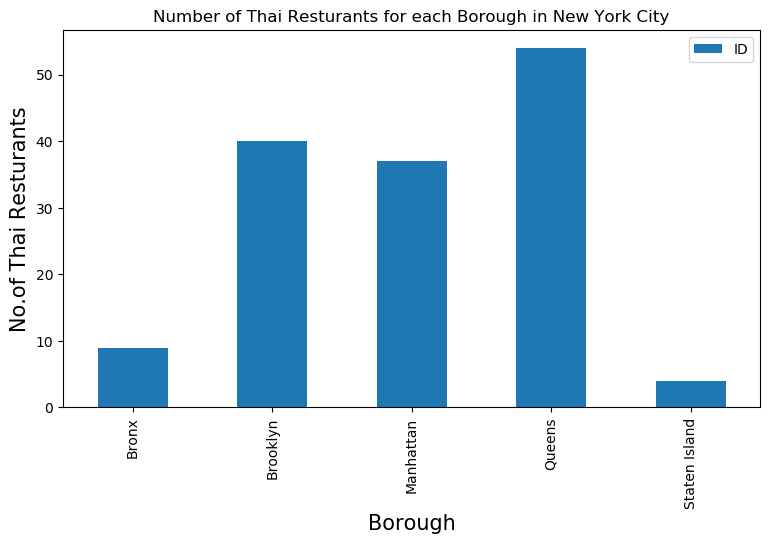

In [51]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Thai Resturants for each Borough in New York City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Thai Resturants', fontsize=15)
Thai_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()
plt.show()

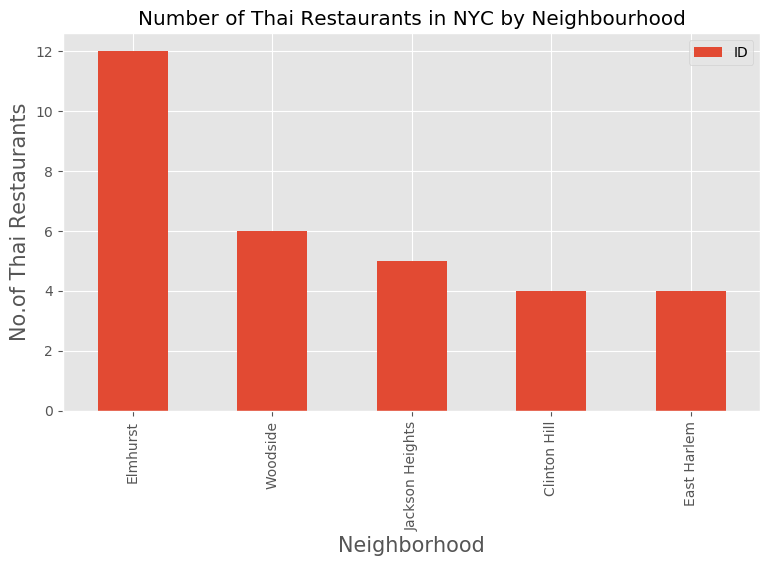

In [52]:
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)

plt.title('Number of Thai Restaurants in NYC by Neighbourhood')

plt.xlabel('Neighborhood', fontsize = 15)

plt.ylabel('No.of Thai Restaurants', fontsize=15)

Thai_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
plt.legend()

plt.show()

In [84]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
Thai_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in Thai_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError: 
        print('No data available for id=',ID)

        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(Thai_rest_ny),')','processed')
    Thai_rest_stats_ny = Thai_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
    

                         ID      Name  Likes  Rating  Tips
0  4b94a4a2f964a520787f34e3  Nam Thai      3     7.1     5
( 1 / 144 ) processed
                         ID      Name  Likes  Rating  Tips
0  4b94a4a2f964a520787f34e3  Nam Thai      3     7.1     5
( 2 / 144 ) processed
                         ID         Name  Likes  Rating  Tips
0  4a739e29f964a520f5dc1fe3  Siam Square     15     6.9    13
( 3 / 144 ) processed
                         ID                   Name  Likes  Rating  Tips
0  4b4c90d3f964a52046b626e3  Honey's Thai Pavilion     19     7.4    28
( 4 / 144 ) processed
                         ID          Name  Likes  Rating  Tips
0  5585c948498e0bd8a8a706f1  Thai Cuisine     17     7.7     1
( 5 / 144 ) processed
                         ID          Name  Likes  Rating  Tips
0  5585c948498e0bd8a8a706f1  Thai Cuisine     17     7.7     1
( 6 / 144 ) processed
                         ID         Name  Likes  Rating  Tips
0  4a739e29f964a520f5dc1fe3  Siam Square     15   

                         ID                  Name  Likes  Rating  Tips
0  5997796d603d2a7019b8c58e  THEP Thai Restaurant     83     8.9    23
( 56 / 144 ) processed
                         ID                       Name  Likes  Rating  Tips
0  57f81d9e498e82d3766ccce8  PuTawn Local Thai Kitchen     27     8.8     7
( 57 / 144 ) processed
                         ID             Name  Likes  Rating  Tips
0  550478fd498ec569ec477a6e  Bangkok Cuisine     57     8.5    26
( 58 / 144 ) processed
                         ID     Name  Likes  Rating  Tips
0  52be229211d2aabfe6f24d20  Up Thai    628     9.2   161
( 59 / 144 ) processed
                         ID                  Name  Likes  Rating  Tips
0  5997796d603d2a7019b8c58e  THEP Thai Restaurant     83     8.9    23
( 60 / 144 ) processed
                         ID               Name  Likes  Rating  Tips
0  42951180f964a52045241fe3  Land Thai Kitchen    341     8.5   146
( 61 / 144 ) processed
                         ID               

                         ID    Name  Likes  Rating  Tips
0  5415d184498ed5a1b577d16c  Thanya      9     6.5     3
( 109 / 144 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c02ca6a0d0e0f470aa9019a
( 110 / 144 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c02ca6a0d0e0f470aa9019a
( 111 / 144 ) processed
                         ID                     Name  Likes  Rating  Tips
0  4bb14694f964a520f5883ce3  Asian Bowl Thai Cuisine      9     6.4     7
( 112 / 144 ) processed
                         ID        Name  Likes  Rating  Tips
0  5ae3a6fda30619002c1490a9  Kin'd Thai     14     8.5     1
( 113 / 144 ) processed
                         ID        Name  Likes  Rating  Tips
0  51cd0030498e1874e3954776  Amina Thai     12     6.9     4
( 114 / 144 ) processed
                         ID           Name  Likes  Rating  Tips
0  457d4c15f964a5201a3f1fe3  Thai Elephant     24 

In [85]:
Thai_rest_stats_ny

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,4b94a4a2f964a520787f34e3,Nam Thai,3,7.1,5
1,Bronx,Kingsbridge,4b94a4a2f964a520787f34e3,Nam Thai,3,7.1,5
2,Manhattan,Marble Hill,4a739e29f964a520f5dc1fe3,Siam Square,15,6.9,13
3,Bronx,Country Club,4b4c90d3f964a52046b626e3,Honey's Thai Pavilion,19,7.4,28
4,Bronx,Parkchester,5585c948498e0bd8a8a706f1,Thai Cuisine,17,7.7,1
5,Bronx,Van Nest,5585c948498e0bd8a8a706f1,Thai Cuisine,17,7.7,1
6,Bronx,Spuyten Duyvil,4a739e29f964a520f5dc1fe3,Siam Square,15,6.9,13
7,Bronx,Spuyten Duyvil,4b94a4a2f964a520787f34e3,Nam Thai,3,7.1,5
8,Bronx,Pelham Bay,4b4c90d3f964a52046b626e3,Honey's Thai Pavilion,19,7.4,28
9,Bronx,Pelham Bay,0,0,0,0.0,0


In [86]:
Thai_rest_stats_ny.to_csv('Thai_rest_stats_ny.csv', index=False)

In [87]:
Thai_rest_stats_ny=pd.read_csv('Thai_rest_stats_ny.csv')

In [88]:
Thai_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,4b94a4a2f964a520787f34e3,Nam Thai,3,7.1,5
1,Bronx,Kingsbridge,4b94a4a2f964a520787f34e3,Nam Thai,3,7.1,5
2,Manhattan,Marble Hill,4a739e29f964a520f5dc1fe3,Siam Square,15,6.9,13
3,Bronx,Country Club,4b4c90d3f964a52046b626e3,Honey's Thai Pavilion,19,7.4,28
4,Bronx,Parkchester,5585c948498e0bd8a8a706f1,Thai Cuisine,17,7.7,1


In [89]:
Thai_rest_stats_ny['Likes']=Thai_rest_stats_ny['Likes'].astype('float64')
Thai_rest_stats_ny['Tips']=Thai_rest_stats_ny['Tips'].astype('float64')

ny_neighborhood_stats=Thai_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [91]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)


,Neighborhood,Average Rating
48,Noho,9.15
9,Chinatown,9.10
42,Little Italy,9.10
41,Lenox Hill,9.05
17,Downtown,9.00
4,Boerum Hill,9.00
23,Flatiron,9.00
62,Soho,8.95
74,Upper East Side,8.90
64,South Ozone Park,8.90


In [92]:

ny_borough_stats=Thai_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [93]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()


,Borough,Average Rating
2,Manhattan,8.445946
1,Brooklyn,8.165000
4,Staten Island,7.500000
3,Queens,7.459259
0,Bronx,6.488889


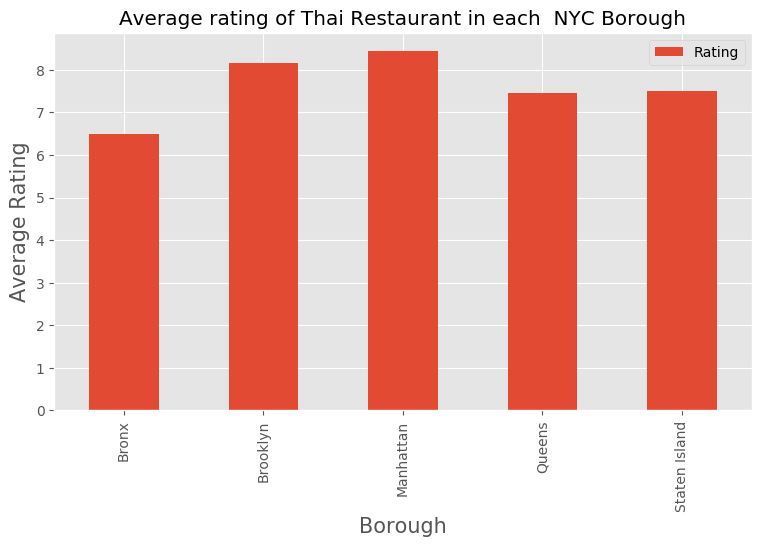

In [94]:

plt.figure(figsize=(9,5), dpi = 100)

plt.title('Average rating of Thai Restaurant in each  NYC Borough')

plt.xlabel('Borough', fontsize = 15)

plt.ylabel('Average Rating', fontsize=15)

Thai_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')

plt.legend()

plt.show()

In [95]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
1,Astoria,8.650000
4,Boerum Hill,9.000000
7,Bushwick,8.800000
8,Carroll Gardens,8.300000
9,Chinatown,9.100000
10,Clinton,8.400000
11,Clinton Hill,8.175000
12,Cobble Hill,8.400000
14,Crown Heights,8.600000
17,Downtown,9.000000


In [96]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)


,Borough,Neighborhood,Latitude,Longitude,Average Rating
26,Manhattan,Noho,40.723259,-73.988434,9.15
4,Manhattan,Chinatown,40.715618,-73.994279,9.10
24,Manhattan,Little Italy,40.719324,-73.997305,9.10
23,Manhattan,Lenox Hill,40.768113,-73.958860,9.05
9,Brooklyn,Downtown,40.690844,-73.983463,9.00
12,Manhattan,Flatiron,40.739673,-73.990947,9.00
1,Brooklyn,Boerum Hill,40.685683,-73.983748,9.00
32,Manhattan,Soho,40.722184,-74.000657,8.95
37,Manhattan,Upper East Side,40.775639,-73.960508,8.90
33,Queens,South Ozone Park,40.668550,-73.809865,8.90


In [97]:
ny_map = folium.Map(location=(40.693943, -73.985880), zoom_start=12)


In [98]:
incidents = folium.map.FeatureGroup()


for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, 
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [99]:

ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [101]:
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        

ny_map.add_child(incidents)